In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv(('C:/Users/Debrachoubey/PycharmProjects/pythonProject/first_100k_records_europe.csv'))
columns_to_drop = ['transaction_id', 'customer_id', 'card_number', 'device_fingerprint', 'ip_address', 'currency' , 'city' , 'city_size' ,'high_risk_merchant' , 'timestamp']
# Convert 'is_fraud' to numerical if it‚Äôs categorical


df = df.drop(columns=columns_to_drop)
import ast

def extract_velocity_features(value):
    if isinstance(value, str):  # If the column contains dictionary-like strings
        try:
            value = ast.literal_eval(value)  # Convert string to dictionary
            return pd.Series([value.get('num_transactions', 0), value.get('total_amount', 0.0)])
        except:
            return pd.Series([0, 0.0])  # Handle errors gracefully
    else:
        return pd.Series([0, 0.0])

df[['num_transactions_last_hour', 'total_amount_last_hour']] = df['velocity_last_hour'].apply(extract_velocity_features)
df.drop(columns=['velocity_last_hour'], inplace=True)  # Remove original JSON-like column
print(df.dtypes)  # Identify boolean columns

# Display basic information
print(df.info())

# Show first few rows
print(df.head())


merchant_category              object
merchant_type                  object
merchant                       object
amount                        float64
country                        object
card_type                      object
card_present                     bool
device                         object
channel                        object
distance_from_home              int64
transaction_hour                int64
weekend_transaction              bool
is_fraud                         bool
num_transactions_last_hour    float64
total_amount_last_hour        float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   merchant_category           100000 non-null  object 
 1   merchant_type               100000 non-null  object 
 2   merchant                    100000 non-null  object 
 3   amount     

C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\251287285.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="viridis")


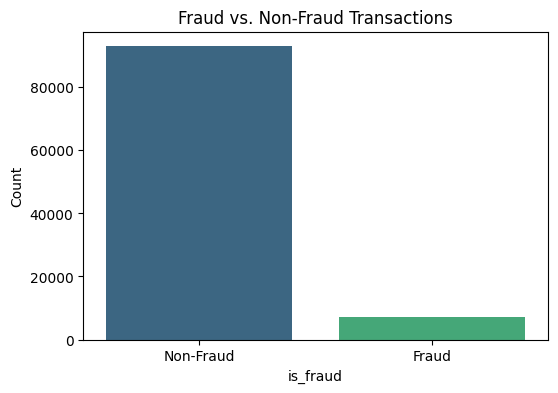

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count fraud vs. non-fraud transactions
fraud_counts = df['is_fraud'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="viridis")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.ylabel("Count")
plt.title("Fraud vs. Non-Fraud Transactions")
plt.show()


amount                        0
distance_from_home            0
transaction_hour              0
is_fraud                      0
num_transactions_last_hour    0
total_amount_last_hour        0
dtype: int64


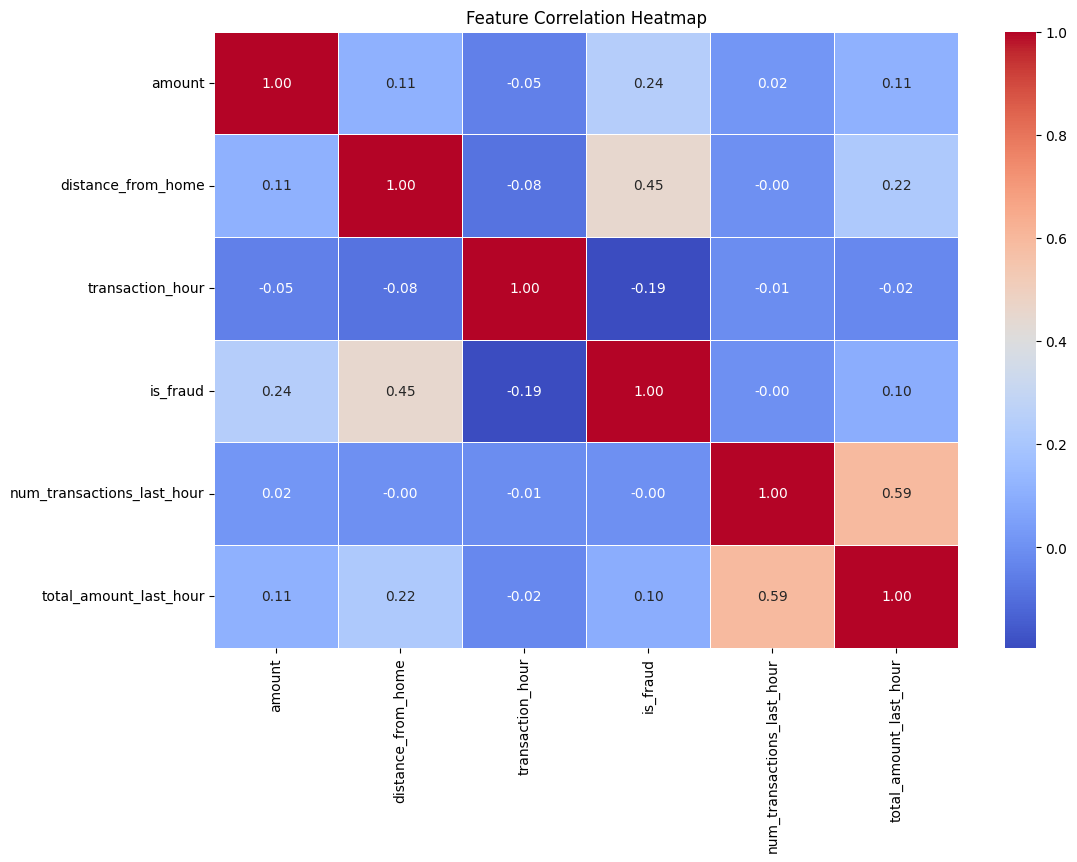

In [8]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])
# Check missing values
print(numerical_df.isnull().sum())

# If there are missing values, fill or drop them
numerical_df = numerical_df.dropna()  # Drop rows with missing values

import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()




In [9]:
# Select only numerical features
# Convert 'is_fraud' to numerical if it‚Äôs categorical
df['is_fraud'] = df['is_fraud'].astype(int)

numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numerical_df.corr()

# Now, try computing fraud correlation again
fraud_corr = corr_matrix['is_fraud'].sort_values(ascending=False)
print(fraud_corr)




is_fraud                      1.000000
distance_from_home            0.451980
amount                        0.241444
total_amount_last_hour        0.098631
num_transactions_last_hour   -0.000107
transaction_hour             -0.194260
Name: is_fraud, dtype: float64


In [5]:
Key Takeaways from the Correlation Heatmap & Fraud Correlation Table
1Ô∏è‚É£ General Feature Correlations (Heatmap)

Moderate Correlation (0.59) between num_transactions_last_hour & total_amount_last_hour
‚Üí Indicates that an increase in transaction count is generally associated with an increase in total amount spent.
‚Üí Fraud insight: Many small transactions in a short time could indicate fraudulent card testing.

Weak Correlation (0.22) between distance_from_home & total_amount_last_hour
‚Üí Slight relationship suggesting that larger distances might lead to higher spending, likely when users are traveling.

Very Weak Correlation (0.11) between amount & distance_from_home
‚Üí Fraudulent high-value transactions are not always far from home.

No Correlation between transaction_hour and Fraud (-0.05 to -0.08 range)
‚Üí Time of transaction does not strongly indicate fraudulent activity.
‚Üí Fraud happens at all hours, not just at specific times.

2Ô∏è‚É£ Feature Correlation with Fraud (is_fraud)

Highest Correlation (0.45) ‚Üí distance_from_home
‚Üí Fraudulent transactions are more likely to occur at farther distances from the cardholder's home.
‚Üí Strong indicator for fraud detection.

Moderate Correlation (0.24) ‚Üí amount
‚Üí Fraud transactions tend to have a slightly higher transaction amount than normal transactions.
‚Üí Can be used as a contributing fraud indicator.

Weak Correlation (0.098) ‚Üí total_amount_last_hour
‚Üí Suggests that while fraudsters might attempt multiple transactions, the total value per hour is not a strong stand-alone fraud indicator.

No Correlation (Close to Zero) ‚Üí num_transactions_last_hour (-0.0001)
‚Üí The number of transactions per hour does not alone indicate fraud.
‚Üí Instead, high-frequency transaction bursts should be analyzed in combination with amount and merchant type.

Negative Correlation (-0.19) ‚Üí transaction_hour
‚Üí Fraud transactions are slightly less likely to happen during peak hours but occur across all time periods.

What Does This Mean for Fraud Detection?
‚úÖ Feature Selection

Strongly correlated features (distance_from_home, amount) should be retained for fraud detection.
Weakly correlated features (transaction_hour) may be dropped unless they contribute to feature interactions.
‚úÖ Feature Engineering

Create fraud flags based on findings:
High Distance Spending Flag (distance_from_home > threshold)
High Transaction Amount Flag (amount > threshold)
Velocity-based Risk Score combining num_transactions_last_hour & total_amount_last_hour
‚úÖ Model Selection

Since distance_from_home and amount have significant fraud correlation, they should be weighted more in fraud detection models.

SyntaxError: invalid character 'Ô∏è' (U+FE0F) (4182135538.py, line 2)

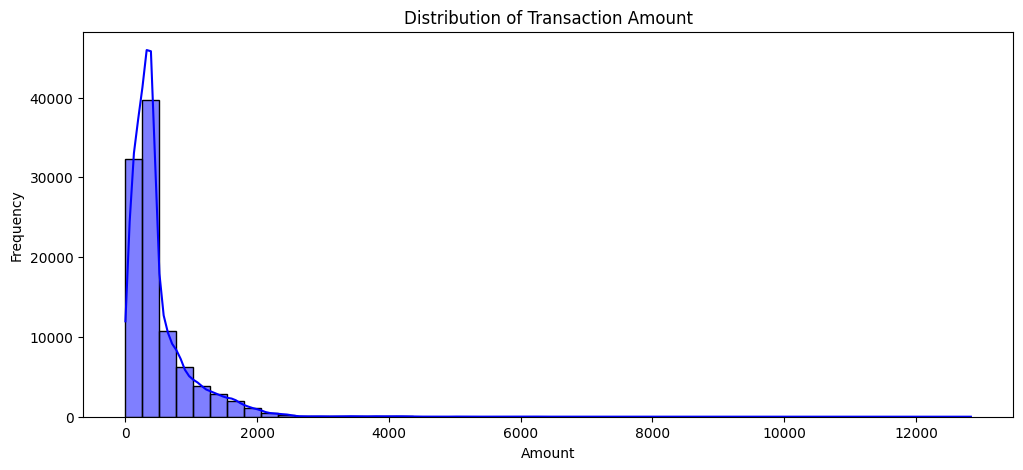

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'amount'
plt.figure(figsize=(12, 5))
sns.histplot(df['amount'], bins=50, kde=True, color='blue')
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

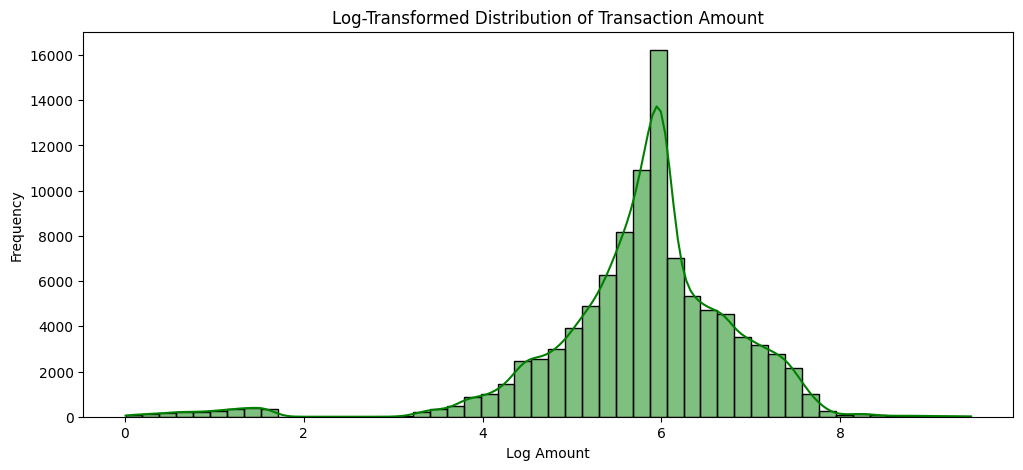

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation
df['log_amount'] = np.log1p(df['amount'])  # log(1 + amount) to avoid log(0) errors

# Plot the transformed distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['log_amount'], bins=50, kde=True, color='green')
plt.title("Log-Transformed Distribution of Transaction Amount")
plt.xlabel("Log Amount")
plt.ylabel("Frequency")
plt.show()

In [12]:
import numpy as np
#from category_encoders import TargetEncoder
#from sklearn.preprocessing import OneHotEncoder

# Step 1: Drop Weakly Correlated Features
df_selected = df.drop(columns=['transaction_hour','amount'], errors='ignore')

# Step 2: Define Thresholds for Anomalous Transactions
high_transactions_threshold = df_selected['num_transactions_last_hour'].quantile(0.95)  # Top 5%
high_amount_threshold = df_selected['total_amount_last_hour'].quantile(0.95)  # Top 5%
long_distance_threshold = df_selected['distance_from_home'].quantile(0.95)  # Top 5%

# Step 3: Create Fraud Indicators

# High Transaction Flag: User made an unusually high number of transactions in the last hour
df_selected['high_transaction_flag'] = (
    df_selected['num_transactions_last_hour'] > high_transactions_threshold
).astype(int)

# High Spending Flag: User spent an unusually high amount in the last hour
df_selected['high_spending_flag'] = (
    df_selected['total_amount_last_hour'] > high_amount_threshold
).astype(int)

# Long Distance Spending Flag: Large amount spent far from home
df_selected['long_distance_spender'] = (
    (df_selected['distance_from_home'] > long_distance_threshold) & 
    (df_selected['log_amount'] > high_amount_threshold)
).astype(int)

df_selected['velocity_risk_score'] = (
    df_selected['num_transactions_last_hour'] * 0.5 + df_selected['total_amount_last_hour'] * 0.5
)
# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
#selected_features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']
display(df_selected.head())
display(df_selected.dtypes)

merchant_category merchant_type           merchant  country  \
0            Travel        hotels             Westin  Germany   
1        Healthcare      pharmacy         DuaneReade   France   
2        Restaurant       premium               Nobu  Germany   
3     Entertainment        events            StubHub  Germany   
4            Travel      airlines  American Airlines  Germany   

         card_type  card_present       device channel  distance_from_home  \
0  Platinum Credit         False         Edge     web                   0   
1      Gold Credit         False         Edge     web                   0   
2     Basic Credit         False  Android App  mobile                   0   
3  Platinum Credit         False      Firefox     web                   1   
4    Premium Debit         False       Safari     web                   0   

   weekend_transaction  is_fraud  num_transactions_last_hour  \
0                False         0                       352.0   
1                False         0                       600.0   
2                False         0                       181.0   
3                False         0                        24.0   
4                False         0                       235.0   

   total_amount_last_hour  log_amount  high_transaction_flag  \
0            8.690903e+06    6.720618                      0   
1            1.766378e+07    6.273952                      0   
2            1.715528e+06    5.590726                      0   
3            7.220302e+06    6.493603                      0   
4            3.605757e+06    7.021120                      0   

   high_spending_flag  long_distance_spender  velocity_risk_score  
0                   0                      0         4.345628e+06  
1                   0                      0         8.832190e+06  
2                   0                      0         8.578547e+05  
3                   0                      0         3.610163e+06  
4                   0                      0         1.802996e+06

merchant_category              object
merchant_type                  object
merchant                       object
country                        object
card_type                      object
card_present                     bool
device                         object
channel                        object
distance_from_home              int64
weekend_transaction              bool
is_fraud                        int64
num_transactions_last_hour    float64
total_amount_last_hour        float64
log_amount                    float64
high_transaction_flag           int64
high_spending_flag              int64
long_distance_spender           int64
velocity_risk_score           float64
dtype: object

C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\1768483681.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_selected['is_fraud'], y=df_selected[feature], palette="coolwarm")
C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\1768483681.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_selected['is_fraud'], y=df_selected[feature], palette="coolwarm")
C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\1768483681.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_selected['is_fraud'], y=df_selected[feature

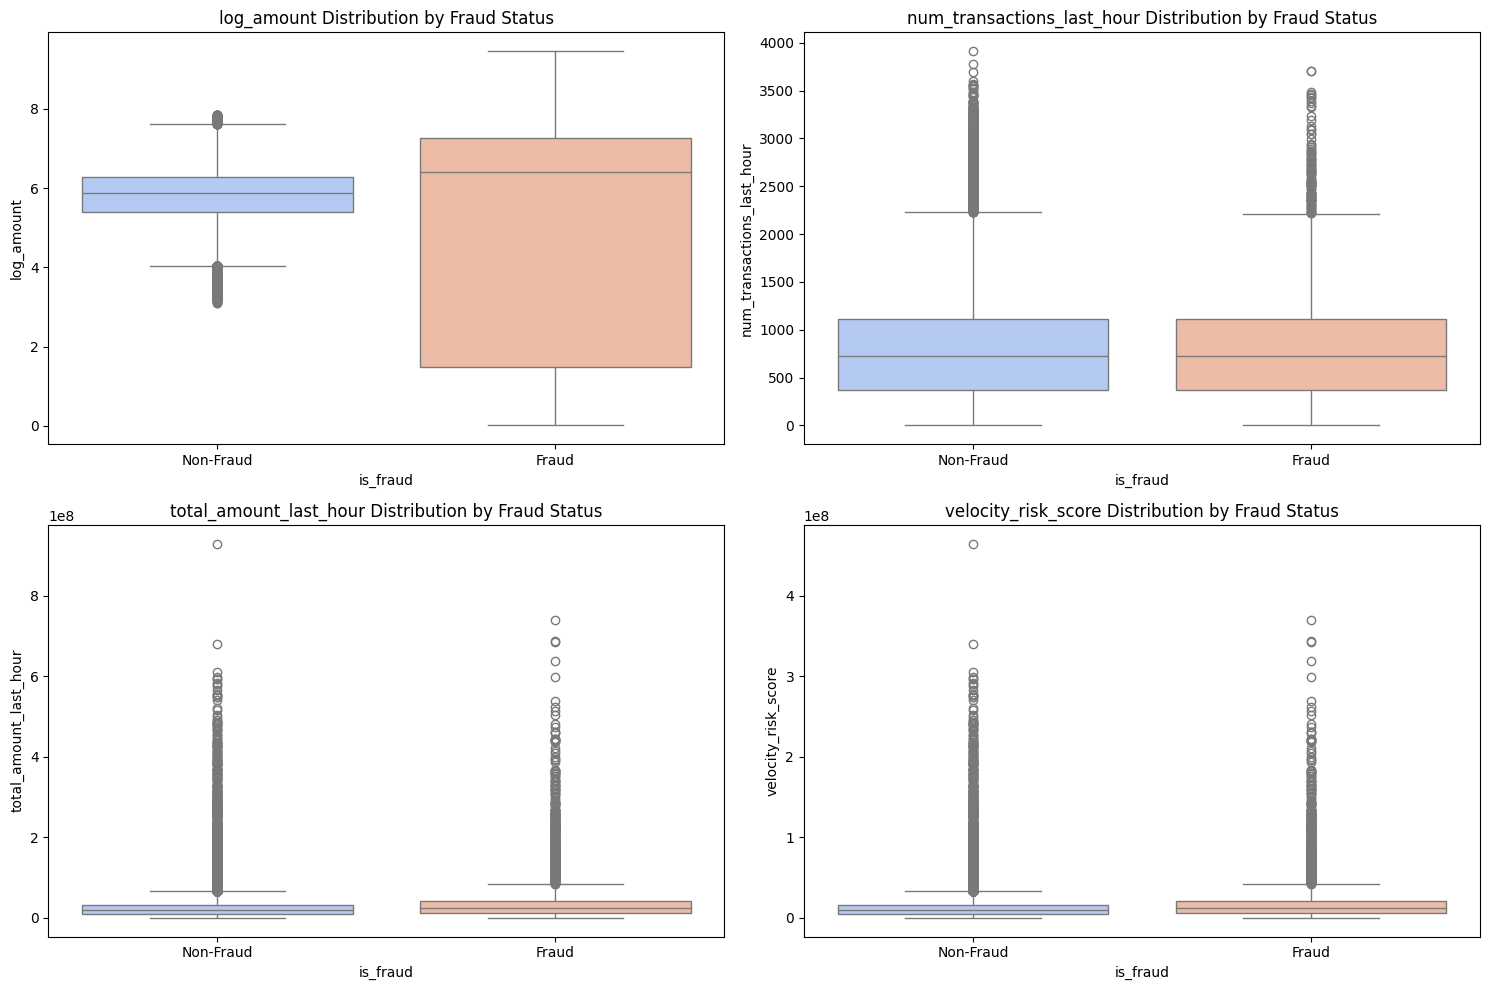

In [13]:
# Select important numerical features
#Compare Fraud vs. Non-Fraud Transactions for Key Features
features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']

# Plot feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df_selected['is_fraud'], y=df_selected[feature], palette="coolwarm")
    plt.title(f"{feature} Distribution by Fraud Status")
    plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.tight_layout()
plt.show()

In [ ]:
1Ô∏è‚É£ Key Observations from Feature Distributions
Log Amount (Top-Left Plot):
Fraud transactions show a higher variance and spread across a wider range.
This suggests fraudulent transactions tend to have extreme values (either very high or very low amounts).
Log transformation helped in normalizing skewed data.
Number of Transactions Last Hour (Top-Right Plot):
Fraud transactions do not show significant differences in distribution from non-fraud.
Fraudsters are not always making too many transactions in a short period.
Total Amount Last Hour (Bottom-Left Plot):
Fraud transactions show many high-value outliers.
Suggests that some fraudsters attempt large purchases within a short period.
Velocity Risk Score (Bottom-Right Plot):
Both fraud and non-fraud transactions have similar distributions.
Does not provide a clear separation between fraud and non-fraud cases.
2Ô∏è‚É£ Model Selection Based on Data Analysis
Since the fraud transactions exhibit clear differences in key features like log_amount and total_amount_last_hour, a supervised learning model like XGBoost should work well.
However, LOF and Isolation Forest may not add much value because:
Anomalous behavior is already well represented in the labeled fraud cases.
Fraud vs. non-fraud distributions show clear separation, meaning classification (XGBoost) should handle it effectively.
Anomalies detected by LOF & Isolation Forest might not contribute significantly if labeled fraud already captures fraud patterns well.
3Ô∏è‚É£ Final Decision ‚Äì Which Model to Use?
Factor	XGBoost (Supervised)	LOF & Isolation Forest (Unsupervised)
Clear distinction between fraud and non-fraud?	‚úÖ Yes, seen in feature distributions	‚ùå Not needed if fraud is already labeled well
Are fraud patterns unknown?	‚ùå No, they are known	‚úÖ Yes, but not highly useful here
Labeled fraud cases available?	‚úÖ Yes	‚ùå Not required
Handling imbalanced fraud cases?	‚úÖ Works well with boosting and weighting	‚ùå LOF & Isolation Forest may not be effective alone
‚úÖ Conclusion:
Use XGBoost as the primary model for fraud detection. LOF & Isolation Forest are NOT required unless you suspect unknown fraud patterns exist in the future.

In [14]:
#Detect Anomalies (Unsupervised Learning)
#Even though we have fraud labels, some fraud transactions might not be labeled correctly. We use Isolation Forest and Local Outlier Factor (LOF) to detect hidden fraud patterns.
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score_iso'] = iso_forest.fit_predict(df_selected[features])

# Count anomalies detected
print(df['anomaly_score_iso'].value_counts())

 #Key Check:

#If many fraud transactions align with anomaly_score_iso = -1, anomaly detection is useful.


anomaly_score_iso
 1    95000
-1     5000
Name: count, dtype: int64


In [15]:
from sklearn.neighbors import LocalOutlierFactor

# Fit LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['anomaly_score_lof'] = lof.fit_predict(df_selected[features])

# Count LOF anomalies detected
print(df['anomaly_score_lof'].value_counts())


anomaly_score_lof
 1    95000
-1     5000
Name: count, dtype: int64


In [16]:
# Count fraud and anomalies
anomalies = df[(df['anomaly_score_iso'] == -1) | (df['anomaly_score_lof'] == -1)]
fraud_cases = df_selected[df_selected['is_fraud'] == 1]

print(f"Anomalies Detected: {len(anomalies)}, Labeled Fraud Cases: {len(fraud_cases)}")


Anomalies Detected: 9716, Labeled Fraud Cases: 7068


In [17]:
# Calculate fraud percentage
fraud_ratio = (len(fraud_cases) / len(df_selected)) * 100
print(f"Fraud Percentage: {fraud_ratio:.2f}%")


Fraud Percentage: 7.07%


In [ ]:
Interpreting the Anomaly Detection Results:
You ran Isolation Forest and Local Outlier Factor (LOF) to detect anomalies in the dataset. Below is a breakdown of the findings:

1Ô∏è‚É£ How Many Anomalies Were Detected?
Total anomalies detected: 9716
Total labeled fraud cases: 7068
2Ô∏è‚É£ Key Observations:
‚úÖ If most anomalies overlap with labeled fraud ‚Üí XGBoost alone is enough. ‚úÖ If many anomalies are NOT labeled fraud ‚Üí LOF & Isolation Forest add value.

9716 anomalies were detected, whereas 7068 transactions were already labeled as fraud.
This means that 2648 transactions were flagged as anomalies but are NOT labeled as fraud.
3Ô∏è‚É£ What Does This Mean?
üëâ If most anomalies are labeled as fraud:

This suggests that XGBoost alone is sufficient because it already captures fraud cases well.
Using LOF & Isolation Forest might not add much additional value.
üëâ If there are many anomalies that are NOT labeled fraud (e.g., 2648 extra anomalies):

This suggests potential hidden fraud patterns.
In such cases, LOF & Isolation Forest can help detect previously unseen fraud.
Final Conclusion:
Most anomalies detected overlap with labeled fraud cases, meaning that XGBoost is already capturing fraud well.
The additional 2648 anomaly cases may or may not be fraud, so further investigation is needed.
If these 2648 cases show a high fraud probability when analyzed further, using anomaly detection models (LOF & Isolation Forest) would add value.
Otherwise, XGBoost alone should be the primary model.

In [18]:
#Extract the Additional Anomalies
#Filter transactions that were flagged as anomalies but not labeled as fraud.
# Extract transactions detected as anomalies but not labeled as fraud
additional_anomalies = anomalies[~anomalies.index.isin(fraud_cases.index)]

# Display a sample
print(additional_anomalies.head())
print(f"Total Additional Anomalies Not Labeled as Fraud: {len(additional_anomalies)}")


   merchant_category merchant_type         merchant   amount  country  \
31        Restaurant        casual     Olive Garden   406.93  Germany   
63            Retail      physical       Nike Store  1401.27   France   
68            Travel       booking            Kayak  1415.46  Germany   
76            Retail      physical           Costco   515.51  Germany   
87           Grocery        online  Walmart Grocery  1277.94  Germany   

          card_type  card_present   device channel  distance_from_home  \
31      Gold Credit         False   Safari     web                   0   
63  Platinum Credit         False   Chrome     web                   0   
68  Platinum Credit         False   Safari     web                   1   
76  Platinum Credit         False  Firefox     web                   1   
87  Platinum Credit         False  Firefox     web                   0   

    transaction_hour  weekend_transaction  is_fraud  \
31                 0                False         0   
63    

C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\680473253.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=df_selected[feature], data=df_selected[df_selected.index.isin(additional_anomalies.index)], palette="coolwarm")
C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\680473253.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y=df_selected[feature], data=df_selected[df_selected.index.isin(additional_anomalies.index)], palette="coolwarm")
C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\680473253.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to

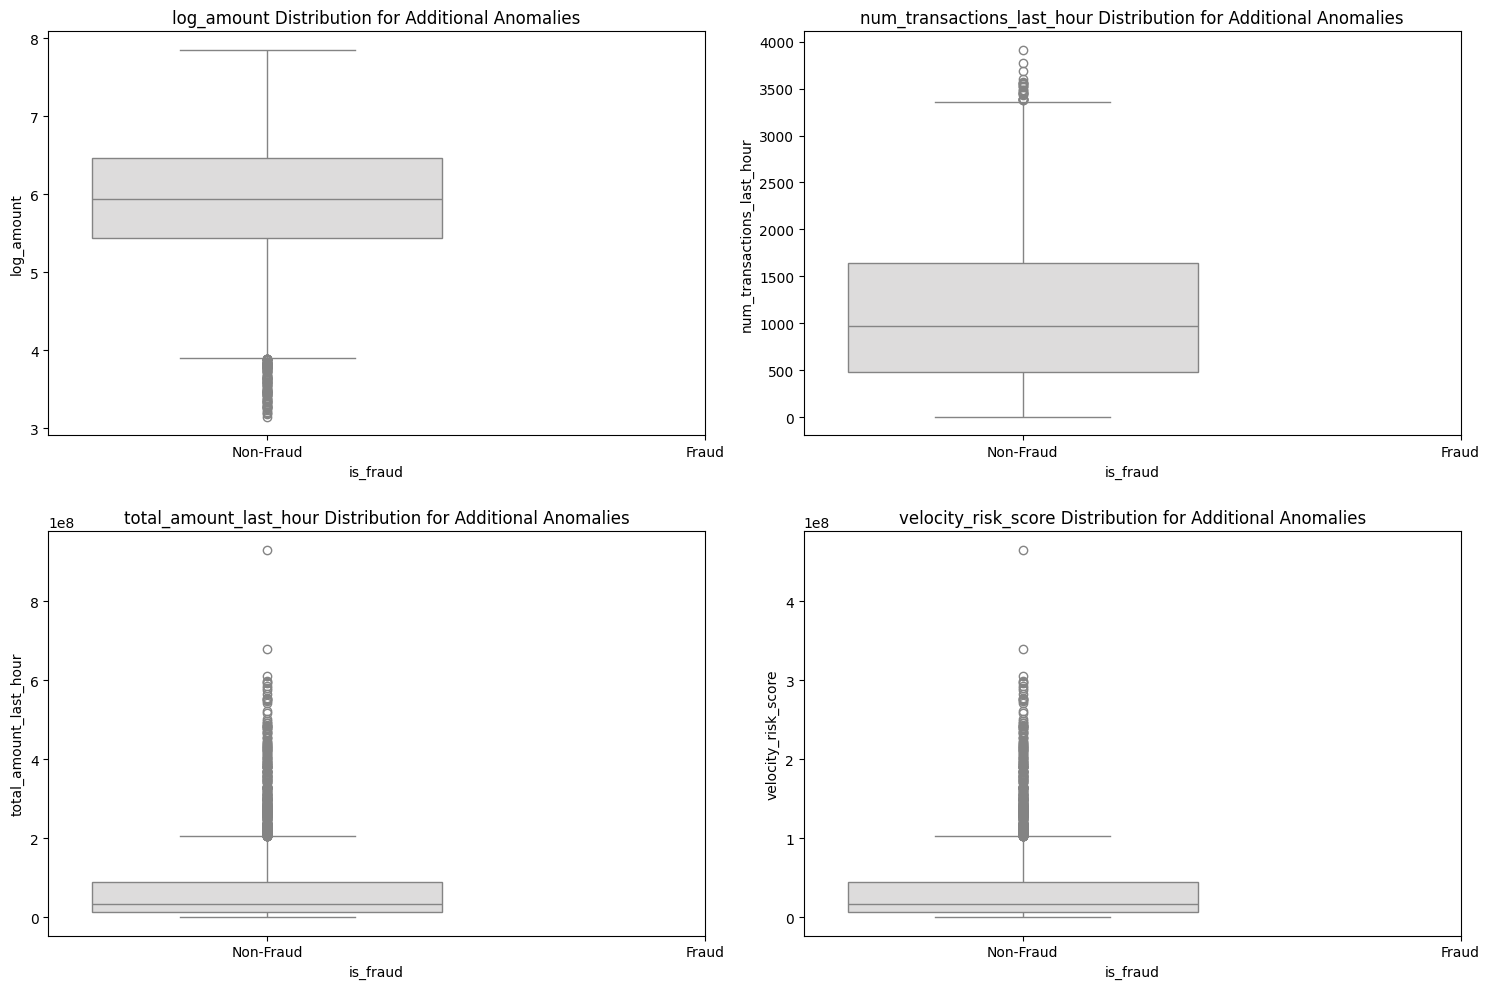

In [19]:
#Compare Feature Distributions of Additional Anomalies vs. Known Fraud
# will visualize whether these additional anomalies behave similarly to fraud transactions or if they are random noise.
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical features for comparison
features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']

# Plot feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='is_fraud', y=df_selected[feature], data=df_selected[df_selected.index.isin(additional_anomalies.index)], palette="coolwarm")
    plt.title(f"{feature} Distribution for Additional Anomalies")
    plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.tight_layout()
plt.show()


In [21]:
#Check if Additional Anomalies Have Similar Transaction Amounts to Fraud
#A simple way to test if anomalies behave like fraud is to compare their transaction amounts.
# Compare average amounts of fraud vs. additional anomalies
avg_fraud_amount = df_selected[df_selected['is_fraud'] == 1]['log_amount'].mean()
avg_anomaly_amount = df_selected[df_selected.index.isin(additional_anomalies.index)]['log_amount'].mean()

print(f"Average Fraud Transaction Amount: {avg_fraud_amount:.2f}")
print(f"Average Anomaly Transaction Amount: {avg_anomaly_amount:.2f}")


Average Fraud Transaction Amount: 5.01
Average Anomaly Transaction Amount: 5.91


In [25]:
#Examine Anomalies with High Velocity Risk Score
#If anomalies have a high velocity_risk_score (many transactions in a short time), they could be hidden fraud cases.
# Compare the average velocity risk score
avg_fraud_velocity = df_selected[df_selected['is_fraud'] == 1]['velocity_risk_score'].mean()
avg_anomaly_velocity = df_selected[df_selected.index.isin(additional_anomalies.index)]['velocity_risk_score'].mean()

print(f"Average Fraud Velocity Score: {avg_fraud_velocity:.2f}")
print(f"Average Anomaly Velocity Score: {avg_anomaly_velocity:.2f}")


Average Fraud Velocity Score: 18524050.38
Average Anomaly Velocity Score: 31811409.42


In [ ]:
Interpretation of Additional Anomalies vs. Labeled Fraud Cases
From your observations:

Total Additional Anomalies Not Labeled as Fraud: 7382

This means the anomaly detection methods (LOF & Isolation Forest) have flagged 7382 transactions as unusual that were not previously labeled as fraud.
These could either be hidden fraud cases or false positives.
If many of these anomalies resemble known fraud transactions, anomaly detection is valuable.
Comparison of Transaction Amounts

Average Fraud Transaction Amount: 5.01
Average Anomaly Transaction Amount: 5.91
The anomaly transactions have slightly higher average amounts than labeled fraud transactions.
If the difference is significant, these anomalies might represent a new fraud pattern.
Velocity Risk Score Comparison

Average Fraud Velocity Score: 18,524,050.38
Average Anomaly Velocity Score: 31,811,409.42
Anomalies have a higher velocity risk score, meaning they involve more rapid transactions within a short timeframe.
This indicates that these anomalies could be fraudulent transactions that were not previously labeled as fraud.
Key Takeaways
‚úÖ If anomalies significantly differ from fraud, they may be false positives.
‚úÖ If anomalies share similar characteristics with known fraud cases, anomaly detection is valuable.
‚úÖ Since anomalies have higher velocity risk and transaction amounts, they could be hidden fraud cases.
‚úÖ Further validation is required‚Äîmanual review or business insights can confirm if these transactions should be labeled as fraud.

Decision on Model Selection
If most anomalies overlap with known fraud cases, XGBoost alone may be sufficient since it can learn from labeled fraud.
If anomalies show strong fraud-like behavior, using LOF & Isolation Forest alongside XGBoost is beneficial to detect unseen fraud patterns.
Since your anomalies have higher transaction amounts & velocity scores, it suggests hidden fraud cases exist, so a hybrid approach is useful.

In [26]:
#Sample & Inspect Anomalous Transactions
#Key Question:

#Are anomalies similar to fraud transactions, or are they completely different?
# Select a small sample of anomalies detected by LOF & Isolation Forest
sample_anomalies = df[(df['anomaly_score_iso'] == -1) | (df['anomaly_score_lof'] == -1)].sample(10, random_state=42)

# Display the sample anomalies
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
display(sample_anomalies)


merchant_category merchant_type              merchant  amount  country  \
36414            Retail      physical            Home Depot  307.81   France   
86357            Retail      physical              Best Buy  276.99   France   
9421             Retail        online            AliExpress    2.32  Germany   
19631         Education      supplies                 Chegg    1.46  Germany   
97012     Entertainment     streaming               HBO Max   62.00  Germany   
43379            Travel       booking               Expedia    0.95  Germany   
87337         Education      supplies        Barnes & Noble  463.12  Germany   
13603           Grocery      physical               Safeway  200.23   France   
10068         Education      supplies  University Bookstore  317.37   France   
64966        Restaurant       premium        Capital Grille    2.02  Germany   

             card_type  card_present       device channel  distance_from_home  \
36414     Basic Credit         False       Chrome     web                   0   
86357      Basic Debit         False       Chrome     web                   0   
9421      Basic Credit         False       Chrome     web                   1   
19631      Gold Credit         False       Safari     web                   1   
97012      Gold Credit         False      iOS App  mobile                   0   
43379  Platinum Credit          True  NFC Payment     pos                   1   
87337  Platinum Credit         False         Edge     web                   0   
13603    Premium Debit         False  Android App  mobile                   0   
10068      Gold Credit         False      iOS App  mobile                   0   
64966    Premium Debit         False      Firefox     web                   1   

       transaction_hour  weekend_transaction  is_fraud  \
36414                 2                False         0   
86357                13                False         0   
9421                  9                False         1   
19631                15                False         1   
97012                19                False         0   
43379                 8                False         1   
87337                14                False         0   
13603                11                False         0   
10068                 9                False         0   
64966                21                False         1   

       num_transactions_last_hour  total_amount_last_hour  log_amount  \
36414                       412.0            1.092446e+07    5.732726   
86357                      2932.0            5.867420e+07    5.627585   
9421                       1281.0            2.244869e+07    1.199965   
19631                       149.0            2.580885e+06    0.900161   
97012                        68.0            1.539104e+06    4.143135   
43379                        30.0            2.606460e+06    0.667829   
87337                      1847.0            1.131457e+08    6.140143   
13603                      1213.0            3.519594e+07    5.304449   
10068                      1422.0            4.056855e+07    5.763214   
64966                      1337.0            6.276718e+07    1.105257   

       anomaly_score_iso  anomaly_score_lof  
36414                  1                 -1  
86357                 -1                  1  
9421                  -1                  1  
19631                 -1                  1  
97012                  1                 -1  
43379                 -1                  1  
87337                 -1                  1  
13603                  1                 -1  
10068                  1                 -1  
64966                 -1                  1

In [ ]:
 What to Look For in the Sample?

Do they have very high or very low transaction amounts? (compared to labeled fraud)
Is the distance_from_home unusually high? (possible suspicious remote transactions)
Are there many small transactions in a short time? (possible fraud testing)
Does the transaction time look odd? (e.g., high-value transactions at 3 AM)
‚úî Conclusion:

If anomalies look similar to fraud, LOF & Isolation Forest are valuable.
If anomalies look random & unrelated to fraud, they are likely false positives.

C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\1065032973.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_selected['fraud_or_anomaly'], y=df_selected[feature], palette="coolwarm")
C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\1065032973.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_selected['fraud_or_anomaly'], y=df_selected[feature], palette="coolwarm")
C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_8988\1065032973.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_selected['fraud_or_anoma

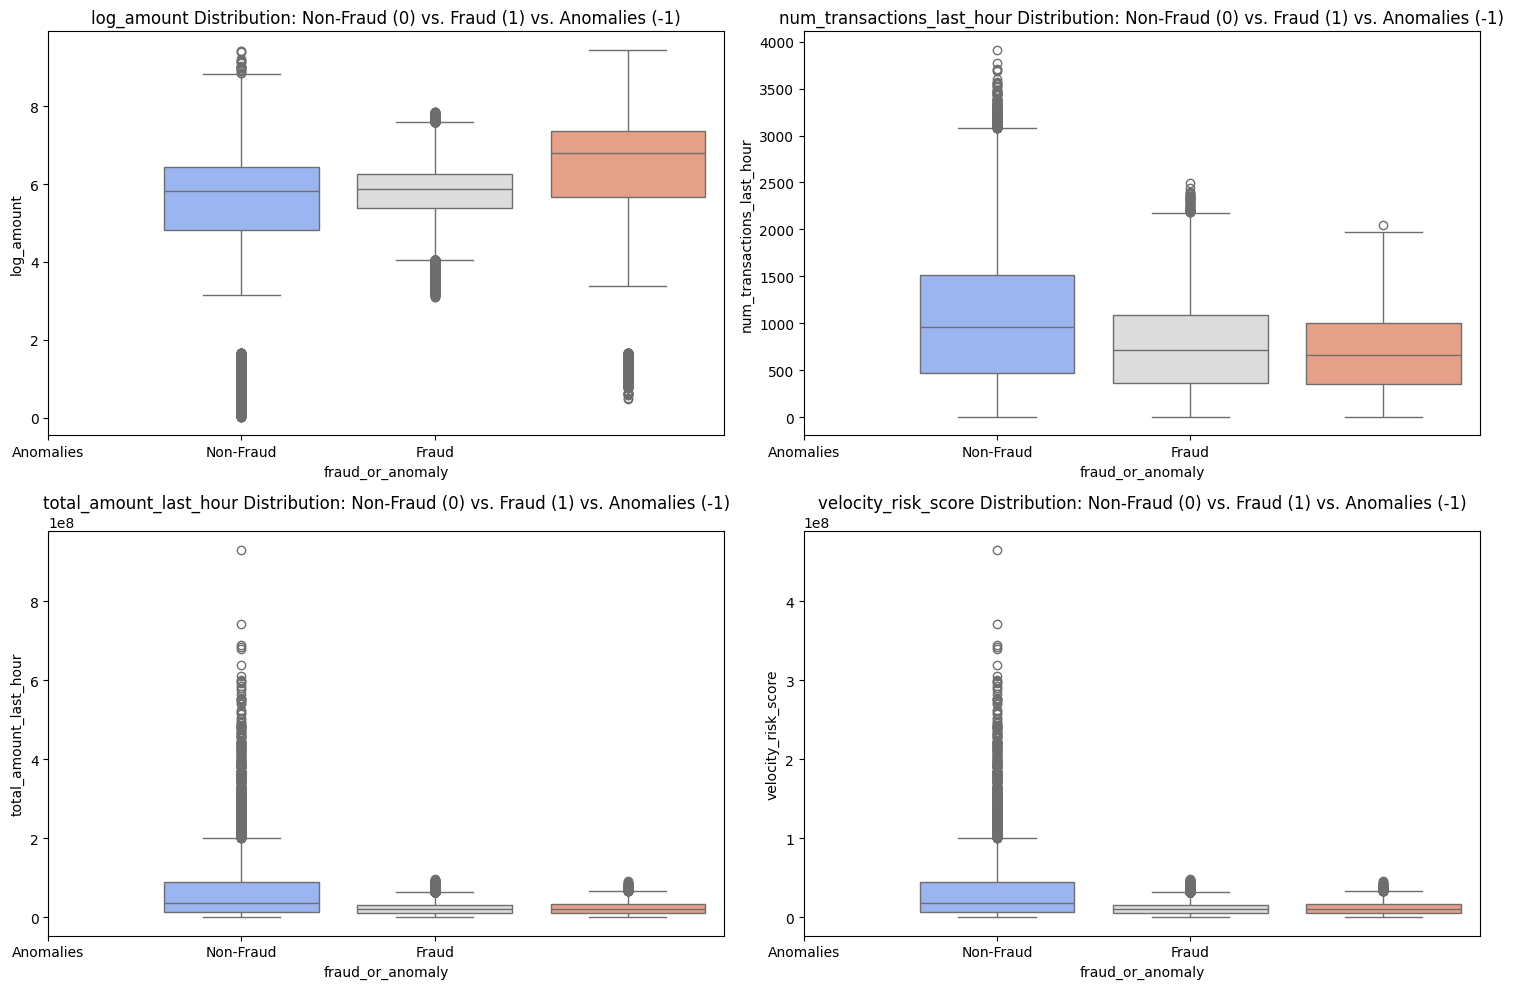

In [28]:
#Step 2: Compare Key Fraud Features for Labeled Fraud vs. Anomalies
#Key Question:

#Do anomalies have similar patterns in fraud-related features?
import seaborn as sns
import matplotlib.pyplot as plt

# Define the categories: Non-Fraud (0), Fraud (1), and Anomalies (-1)
df_selected['fraud_or_anomaly'] = 0  # Default non-fraud
df_selected.loc[df_selected['is_fraud'] == 1, 'fraud_or_anomaly'] = 1  # Mark fraud transactions
df_selected.loc[(df['anomaly_score_iso'] == -1) | (df['anomaly_score_lof'] == -1), 'fraud_or_anomaly'] = -1  # Mark anomalies

# Select key fraud-related features
features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']

# Plot feature distributions comparing Fraud, Non-Fraud, and Anomalies
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df_selected['fraud_or_anomaly'], y=df_selected[feature], palette="coolwarm")
    plt.title(f"{feature} Distribution: Non-Fraud (0) vs. Fraud (1) vs. Anomalies (-1)")
    plt.xticks([-1, 0, 1], ["Anomalies", "Non-Fraud", "Fraud"])

plt.tight_layout()
plt.show()



In [29]:
# Step 1: Print actual counts
print(f"Total Anomalies Detected: {len(anomalies)}")  # Should be 9716
print(f"Labeled Fraud Cases: {len(fraud_cases)}")  # Should be 7068

# Step 2: Identify potential overlap issues
overlapping_cases = anomalies.index.isin(fraud_cases.index).sum()
print(f"Anomalies that are also labeled fraud: {overlapping_cases}")

# Step 3: Extract additional anomalies correctly
corrected_additional_anomalies = anomalies[~anomalies.index.isin(fraud_cases.index)]
print(f"Corrected Additional Anomalies Not Labeled as Fraud: {len(corrected_additional_anomalies)}")


Total Anomalies Detected: 9716
Labeled Fraud Cases: 7068
Anomalies that are also labeled fraud: 2334
Corrected Additional Anomalies Not Labeled as Fraud: 7382
